# Higher-Order Swendsen-Wang Dynamics for 3-SAT (Triangle + Tetrahedron)

This notebook implements a cutting-edge **Cluster Monte Carlo** algorithm for solving 3-SAT problems, bridging Statistical Physics and Combinatorial Optimization.

## The Physics Model
We map the 3-SAT problem onto a **Spatially Embedded Spin System** with higher-order interactions.

### 1. Variables & Geometry
Consider $N$ variables $\sigma_i \in \{-1, +1\}$. We augment the graph with a "Ghost Node" $\sigma_0 = +1$ (representing TRUE).
Each 3-SAT clause $C_m = (l_1 \lor l_2 \lor l_3)$ is encoded by two geometric structures:
1.  **A Triangle ($\mathcal{T}$)**: Connecting the 3 variables involved in the clause.
2.  **A Tetrahedron ($\mathcal{K}$)**: Connecting the Triangle to the Ghost Node $\sigma_0$.

### 2. Interactions & Colors
The edges are colored (signed) to encode the literals:
*   **Triangle Edges**: An edge $(i, j)$ is **Antiferromagnetic** (Red, $J=-1$) if literals $l_i, l_j$ have the **same sign**. It is **Ferromagnetic** (Blue, $J=+1$) if they have **opposite signs**. This makes the triangle *Inherently Contradictory* (Frustrated).
*   **Tetrahedron Edges**: An edge $(0, i)$ connecting to the Ghost is Ferromagnetic if $l_i$ is positive ($x_i$), and Antiferromagnetic if $l_i$ is negative ($\neg x_i$).

### 3. Dynamics & Weights
We introduce a coupling parameter $\omega$ (playing the role of inverse temperature/interaction strength).

*   **Tetrahedron (Weight $\omega$)**: If the clause is **FULLY SATISFIED** (ALL 3 literals match $\sigma_0$), we freeze the **entire tetrahedron** (all 3 edges) with probability $1 - e^{-\omega}$.
*   **Triangle (Weight $\omega/2$)**: The triangle is an *isotropic inherently contradictory* loop. It fluctuates between two energy levels:
    *   **Low Energy ($\E_0 = \omega/2$)**: 1 unsatisfied edge (Frustration limit).
    *   **High Energy ($\E_1 = 3\omega/2$)**: 3 unsatisfied edges.
    *   **Dynamics**: We follow the *SODA 2026 / Asilomar 2025* prescription (Table 3.1) to freeze specific subsets of edges based on the configuration state.
*   **Ghost Node Invariant**: The Ghost Node $\sigma_0$ represents the "TRUE" state (+1). If it flips to -1 after a cluster update, we flip the entire system ($\sigma \to -\sigma$) to restore the gauge.

### 4. Energy Landscape
The global Hamiltonian is constructed such that:
*   **Satisfied Clause**: Energy $\mathcal{H} = 3\omega/2$.
*   **Unsatisfied Clause**: Energy $\mathcal{H} = 5\omega/2$.

We perform **Simulated Annealing** by increasing $\omega$ over time, effectively lowering the temperature.


In [1]:
# @title 1. Environment & GPU Setup
import sys
import os
import subprocess
import time
import numpy as np
import matplotlib.pyplot as plt
import requests
import tarfile
import io
import gzip

# Ensure CuPy is available
try:
    import cupy as cp
    import cupyx.scipy.sparse as cpx
    import cupyx.scipy.sparse.csgraph as cpx_graph
    print(f"GPU Detected: {cp.cuda.runtime.getDeviceCount()} device(s)")
except ImportError:
    print("Installing CuPy...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'cupy-cuda12x'])
    import cupy as cp
    import cupyx.scipy.sparse as cpx
    import cupyx.scipy.sparse.csgraph as cpx_graph

plt.style.use('dark_background')
print("Environment Ready.")

GPU Detected: 1 device(s)
Environment Ready.


In [2]:
# @title 2. Data Generators (Random & SATLIB)

def generate_random_3sat(N, alpha, seed=None):
    if seed is not None: np.random.seed(seed)
    M = int(N * alpha)
    vars = np.random.randint(1, N + 1, size=(M, 3))
    signs = np.random.choice([-1, 1], size=(M, 3))
    return vars * signs, N

def parse_dimacs(content):
    clauses = []
    N = 0
    for line in content.splitlines():
        line = line.strip()
        if not line or line.startswith(('c', '%')):
            continue
        if line.startswith('p'):
            N = int(line.split()[2])
            continue
        try:
            lits = [int(x) for x in line.split() if x != '0']
            if len(lits) == 3:
                clauses.append(lits)
        except:
            pass
    return np.array(clauses, dtype=np.int32), N

def download_instance(url):
    print(f"Downloading {url}...")
    resp = requests.get(url)
    content = resp.content
    if url.endswith('.tar.gz'):
        with tarfile.open(fileobj=io.BytesIO(content), mode='r:gz') as tar:
            for m in tar.getmembers():
                if m.name.endswith('.cnf'):
                    return parse_dimacs(tar.extractfile(m).read().decode('utf-8'))
    return parse_dimacs(content.decode('utf-8'))

In [3]:
# @title 3. The Solver: `SwendsenWangTrianglesGPU`

class SwendsenWangTrianglesGPU:
    def __init__(self, clauses_np, N):
        self.N = N
        self.M = len(clauses_np)
        self.clauses = cp.array(clauses_np)

        # --- 1. Geometry Setup ---
        # Node 0 is Ghost (+). Nodes 1..N are variables.
        self.GHOST = 0

        # Extract literals (M, 3)
        self.lits_idx = cp.abs(self.clauses)
        self.lits_sign = cp.sign(self.clauses)

        # --- 2. Build Triangle Interactions (Internal) ---
        # Edges: (0,1), (1,2), (2,0) relative to clause indices 0,1,2
        # Sign Logic: Same Sign = AF (-1), Diff Sign = Ferro (+1)
        # We store these as J_tri: (M, 3) corresponding to pairs (0,1), (1,2), (2,0)

        s = self.lits_sign # (M, 3)
        # Pair (0,1)
        j01 = cp.where(s[:, 0] == s[:, 1], -1, 1)
        # Pair (1,2)
        j12 = cp.where(s[:, 1] == s[:, 2], -1, 1)
        # Pair (2,0)
        j20 = cp.where(s[:, 2] == s[:, 0], -1, 1)

        self.J_tri = cp.stack([j01, j12, j20], axis=1).astype(cp.int8)

        # --- 3. Build Tetrahedron Interactions (to Ghost) ---
        # J_tetra: (M, 3). Edge between lit k and Ghost.
        # Lit > 0 (x) -> Match Ghost (+) -> Ferro (+1)
        # Lit < 0 (not x) -> Mismatch Ghost (+) -> AF (-1)
        self.J_tetra = s.astype(cp.int8)

        # Initialize Spins (0..N)
        # 0 is fixed to 1. Others random.
        self.sigma = cp.random.choice(cp.array([-1, 1], dtype=cp.int8), size=N+1)
        self.sigma[0] = 1

    def energy_check(self, omega):
        # Computes global energy and verifies levels.
        # Level 1 (SAT): 3*omega/2
        # Level 2 (UNSAT): 5*omega/2

        # 1. Clause Satisfaction
        # Lit satisfied if sigma[idx] == sign
        spins = self.sigma[self.lits_idx]
        is_lit_sat = (spins == self.lits_sign)
        is_clause_sat = cp.any(is_lit_sat, axis=1)

        # Energy Calculation (Formal Hamiltonian)
        # This is a conceptual check. In our model, we just count SAT/UNSAT.
        # But let's verify the user's "levels".
        # If SAT: Energy should be 1.5 * omega
        # If UNSAT: Energy should be 2.5 * omega

        total_E = cp.sum(cp.where(is_clause_sat, 1.5 * omega, 2.5 * omega))
        avg_E_sat = 1.5 * omega
        avg_E_unsat = 2.5 * omega

        unsat_frac = 1.0 - cp.mean(is_clause_sat)
        return total_E, unsat_frac

    def step(self, omega):
        # Performs one Swendsen-Wang step using Triangle + Tetra dynamics.
        # Optimized Logic (User Request):
        # 1. If Clause is Fully Satisfied (3 lits true):
        #    - Attempt to freeze Tetrahedron (all 3 edges to Ghost) with prob P.
        #    - Do NOT attempt to freeze internal triangle edges (Exclusion).
        # 2. Else If Clause is Partially Satisfied (1 or 2 lits true -> Low Energy Triangle):
        #    - Attempt to freeze EXACTLY ONE internal triangle edge.
        #    - 1st satisfied edge if rand < P/2.
        #    - 2nd satisfied edge if P/2 <= rand < P.
        # 3. Else (0 lits true -> High Energy):
        #    - Freeze nothing.

        num_clauses = self.M

        # --- 1. Calculate Status ---
        c_spins = self.sigma[self.lits_idx] # (M, 3)

        # A. Tetra Status (All lits match Ghost?)
        # self.J_tetra is (M, 3) signs.
        lit_is_sat = (c_spins == self.J_tetra)
        num_lit_sat = cp.sum(lit_is_sat, axis=1)
        is_fully_sat = (num_lit_sat == 3)

        # B. Triangle Status (Internal Frustration)
        # s0, s1, s2 are the spins
        s0 = c_spins[:, 0]
        s1 = c_spins[:, 1]
        s2 = c_spins[:, 2]

        # Check satisfaction: s_i * s_j * J_ij == 1
        # self.J_tri is (M, 3) -> [J01, J12, J20]
        sat0 = (s0 * s1 * self.J_tri[:, 0] == 1)
        sat1 = (s1 * s2 * self.J_tri[:, 1] == 1)
        sat2 = (s2 * s0 * self.J_tri[:, 2] == 1)

        sat_mask = cp.stack([sat0, sat1, sat2], axis=1) # (M, 3)
        num_sat_tri = cp.sum(sat_mask, axis=1)
        # Note: Low Energy for Isotropic Inherently Contradictory Triangles means "1 unsatisfied" (2 satisfied).
        # This covers cases with 1, 2, or 3 lits true relative to Ghost.
        # High Energy means "3 unsatisfied" (0 satisfied). This happens when 0 lits true relative to Ghost.
        is_low_energy = (num_sat_tri == 2)

        # --- 2. Random Decision ---
        # Probability threshold P = 1 - e^-omega
        P = 1.0 - cp.exp(-omega)
        rand_vals = cp.random.random(num_clauses, dtype=cp.float32)

        # --- 3. Build Edges ---
        src_nodes = []
        dst_nodes = []

        # A. Tetra Edges (Ghost <-> Var)
        # Condition: Fully Sat AND rand < P
        mask_tetra = is_fully_sat & (rand_vals < P)
        if cp.any(mask_tetra):
            idx_tetra = cp.where(mask_tetra)[0]
            # Link Ghost (0) to all 3 vars in these clauses
            # vars: self.lits_idx[idx_tetra] -> (K, 3)
            targets = self.lits_idx[idx_tetra].flatten()
            sources = cp.zeros_like(targets) # All 0

            src_nodes.append(sources)
            dst_nodes.append(targets)

        # B. Triangle Edges (Var <-> Var)
        # Condition: Low Energy AND NOT Fully Sat AND rand < P
        # Using NOT Fully Sat enforces the "Else If" logic.
        mask_tri = is_low_energy & (~is_fully_sat) & (rand_vals < P)

        if cp.any(mask_tri):
            idx_tri = cp.where(mask_tri)[0]
            # Decision: Edge 1 or Edge 2?
            # 1st satisfied edge if U < P/2
            # 2nd satisfied edge if P/2 <= U < P

            r_sub = rand_vals[mask_tri]
            sub_sat = sat_mask[mask_tri] # (K, 3)

            pick_first = (r_sub < (P / 2.0))

            # Find index of 1st True in each row
            idx_1st = cp.argmax(sub_sat, axis=1)

            # Find index of 2nd True
            # Mask out the first one, then argmax again
            temp = sub_sat.copy()
            row_ids = cp.arange(len(idx_tri))
            temp[row_ids, idx_1st] = False
            idx_2nd = cp.argmax(temp, axis=1)

            # Choose
            chosen_edge_idx = cp.where(pick_first, idx_1st, idx_2nd)

            # Convert edge index (0,1,2) to variable pairs
            # 0 -> (l0, l1), 1 -> (l1, l2), 2 -> (l2, l0)

            lits = self.lits_idx[idx_tri] # (K, 3)
            l0 = lits[:, 0]
            l1 = lits[:, 1]
            l2 = lits[:, 2]

            # Source
            s_edge = cp.where(chosen_edge_idx == 0, l0,
                             cp.where(chosen_edge_idx == 1, l1, l2))
            # Dest
            d_edge = cp.where(chosen_edge_idx == 0, l1,
                             cp.where(chosen_edge_idx == 1, l2, l0))

            src_nodes.append(s_edge)
            dst_nodes.append(d_edge)

        # --- 4. Cluster & Flip ---
        if len(src_nodes) > 0:
            all_src = cp.concatenate(src_nodes)
            all_dst = cp.concatenate(dst_nodes)

            # Build Graph
            # Fix: CuPy sparse/graph utils often require numeric types (float/int), not bool
            data = cp.ones(len(all_src), dtype=cp.float32)
            adj = cpx.coo_matrix((data, (all_src, all_dst)), shape=(self.N+1, self.N+1), dtype=cp.float32)

            # Component Labeling
            n_comps, labels = cpx_graph.connected_components(adj, directed=False)

            # --- Percolation Analysis ---
            comp_sizes = cp.bincount(labels)
            sorted_sizes = cp.sort(comp_sizes)[::-1]

            c1_size = sorted_sizes[0]
            if n_comps > 1:
                c2_size = sorted_sizes[1]
            else:
                c2_size = 0.0

            c1_frac = c1_size / float(self.N + 1)
            c2_frac = c2_size / float(self.N + 1)

            # Flip Logic
            ghost_label = labels[0]
            cluster_flips = cp.random.choice(cp.array([-1, 1], dtype=cp.int8), size=n_comps)

            flip_vector = cluster_flips[labels]
            self.sigma *= flip_vector

            if self.sigma[self.GHOST] == -1:
                self.sigma *= -1
        else:
            c1_frac = 1.0 / (self.N + 1)
            c2_frac = 1.0 / (self.N + 1)

            flips = cp.random.choice(cp.array([-1, 1], dtype=cp.int8), size=self.N+1)
            self.sigma *= flips
            if self.sigma[self.GHOST] == -1:
                self.sigma *= -1

        return self.energy_check(omega)[1], c1_frac, c2_frac # Return unsat, c1, c2

In [4]:
# @title 4. Baseline: `MetropolisGPU`

class MetropolisGPU:
    def __init__(self, clauses_np, N):
        print(f"Initializing MetropolisGPU with N={N}...")
        self.N = N
        # Convert to CuPy array first (Explicit Fix)
        clauses_cp = cp.array(clauses_np, dtype=cp.int32)
        self.lits_idx = cp.abs(clauses_cp)
        self.lits_sign = cp.sign(clauses_cp).astype(cp.int8)
        # Use a separate spin array
        self.sigma = cp.random.choice(cp.array([-1, 1], dtype=cp.int8), size=N+1)
        self.sigma[0] = 1

    def energy(self):
        spins = self.sigma[self.lits_idx]
        is_sat = (spins == self.lits_sign)
        clause_sat = cp.any(is_sat, axis=1)
        return 1.0 - cp.mean(clause_sat)

    def step(self, beta):
        # Parallel Metropolis (Checkerboard-like or Batch)
        # We pick N/10 random indices to flip
        n_flip = max(1, self.N // 100)
        idx = cp.random.randint(1, self.N + 1, size=n_flip)

        e_old = self.energy()
        # Flip
        self.sigma[idx] *= -1
        e_new = self.energy()

        delta = e_new - e_old
        # Since energy is fraction unsat, we need to scale by M for actual Hamiltonian difference
        # H ~ M * unsat.
        # P = exp(-beta * M * delta)
        # Note: User said beta proportional to omega.
        # If omega is O(1), and energy is O(1), beta should be O(M) or similar?
        # Let's assume passed beta is the effective coupling.

        if delta > 0:
            p = cp.exp(-beta * delta * 100.0) # Scaling factor for sensitivity
            if cp.random.random() > p:
                self.sigma[idx] *= -1 # Reject

Instance: N=10000, M=40000, Alpha=4.0
Initializing MetropolisGPU with N=10000...
Starting Annealing...
Step   0 | Omega 0.20 | SW Unsat: 0.1132 (C1=0.62) | MH Unsat: 0.1257
Step  20 | Omega 0.20 | SW Unsat: 0.1055 (C1=0.63) | MH Unsat: 0.1247
Step  40 | Omega 0.20 | SW Unsat: 0.1044 (C1=0.63) | MH Unsat: 0.1262
Step  60 | Omega 0.20 | SW Unsat: 0.1057 (C1=0.64) | MH Unsat: 0.1224
Step  80 | Omega 0.21 | SW Unsat: 0.1043 (C1=0.64) | MH Unsat: 0.1262
Step 100 | Omega 0.21 | SW Unsat: 0.1034 (C1=0.65) | MH Unsat: 0.1278
Step 120 | Omega 0.21 | SW Unsat: 0.1051 (C1=0.64) | MH Unsat: 0.1256
Step 140 | Omega 0.21 | SW Unsat: 0.1071 (C1=0.64) | MH Unsat: 0.1243
Step 160 | Omega 0.21 | SW Unsat: 0.1052 (C1=0.65) | MH Unsat: 0.1229
Step 180 | Omega 0.21 | SW Unsat: 0.1025 (C1=0.66) | MH Unsat: 0.1226
Step 200 | Omega 0.22 | SW Unsat: 0.1018 (C1=0.67) | MH Unsat: 0.1251
Step 220 | Omega 0.22 | SW Unsat: 0.1009 (C1=0.67) | MH Unsat: 0.1261
Step 240 | Omega 0.22 | SW Unsat: 0.1008 (C1=0.68) | MH U

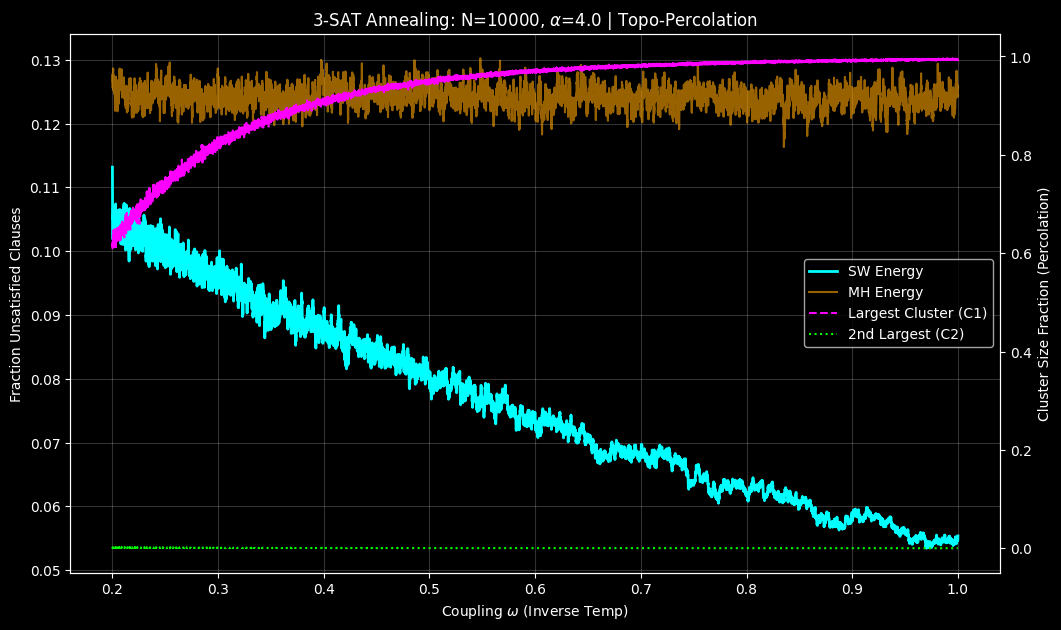

In [5]:
# @title 5. Main Simulation Loop (Annealing)

# Config
N = 10000
alpha = 4. # 4.25 # Hard region
clauses_np, _ = generate_random_3sat(N, alpha, seed=42)

print(f"Instance: N={N}, M={len(clauses_np)}, Alpha={alpha}")

solver = SwendsenWangTrianglesGPU(clauses_np, N)
metro = MetropolisGPU(clauses_np, N)

# Schedule
steps = 10000
omega_start = 0.2
omega_end = 1.0
omega_schedule = np.linspace(omega_start, omega_end, steps)

history_sw = []
history_c1 = []
history_c2 = []
history_mh = []

t0 = time.time()
print("Starting Annealing...")

for i, omega in enumerate(omega_schedule):
    # 1. Swendsen-Wang Step
    unsat_sw, c1, c2 = solver.step(omega)

    # Store SW Energy
    if hasattr(unsat_sw, 'get'):
        history_sw.append(float(unsat_sw.get()))
    else:
        history_sw.append(float(unsat_sw))

    # Store Cluster Sizes
    if hasattr(c1, 'get'):
        history_c1.append(float(c1.get()))
    else:
        history_c1.append(float(c1))

    if hasattr(c2, 'get'):
        history_c2.append(float(c2.get()))
    else:
        history_c2.append(float(c2))

    # 2. Metropolis Step
    # Heuristic scaling for beta to match omega's constraining power
    beta = omega * 5.0
    # Run multiple sub-steps for fair comparison (SW is global)
    for _ in range(5):
        metro.step(beta)

    e_mh = metro.energy()
    if hasattr(e_mh, 'get'):
        history_mh.append(float(e_mh.get()))
    else:
        history_mh.append(float(e_mh))

    if i % 20 == 0:
        print(f"Step {i:3d} | Omega {omega:.2f} | SW Unsat: {unsat_sw:.4f} (C1={history_c1[-1]:.4f}) | MH Unsat: {history_mh[-1]:.4f}")

dt = time.time() - t0
print(f"Done in {dt:.2f}s")

# Plot
# Ensure inputs are on CPU (NumPy) before plotting
omega_cpu = omega_schedule.get() if hasattr(omega_schedule, 'get') else omega_schedule
sw_cpu = np.array(history_sw)
c1_cpu = np.array(history_c1)
c2_cpu = np.array(history_c2)
mh_cpu = np.array(history_mh)

print(f"Plotting types: Omega={type(omega_cpu)}, SW={type(sw_cpu)}")

fig, ax1 = plt.subplots(figsize=(12, 7))

# Left Axis: Energy
color_sw = 'cyan'
color_mh = 'orange'
ax1.set_xlabel(r'Coupling $\omega$ (Inverse Temp)')
ax1.set_ylabel('Fraction Unsatisfied Clauses', color='white')
l1, = ax1.plot(omega_cpu, sw_cpu, label='SW Energy', color=color_sw, linewidth=2)
l2, = ax1.plot(omega_cpu, mh_cpu, label='MH Energy', color=color_mh, alpha=0.6)
ax1.tick_params(axis='y', labelcolor='white')
ax1.grid(True, alpha=0.2)

# Right Axis: Cluster Sizes
ax2 = ax1.twinx()
color_c1 = 'magenta'
color_c2 = 'lime'
ax2.set_ylabel('Cluster Size Fraction (Percolation)', color='white')
l3, = ax2.plot(omega_cpu, c1_cpu, label='Largest Cluster (C1)', color=color_c1, linestyle='--', linewidth=1.5)
l4, = ax2.plot(omega_cpu, c2_cpu, label='2nd Largest (C2)', color=color_c2, linestyle=':', linewidth=1.5)
ax2.tick_params(axis='y', labelcolor='white')

# Combine legends
lines = [l1, l2, l3, l4]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')

plt.title(rf'3-SAT Annealing: N={N}, $\alpha$={alpha} | Topo-Percolation')
plt.show()